# HW5 Kaggle Competition
#### Riley Hora, riho1074
#### Artificial Intelligence-Fall 2023

### Problem
In the Kaggle Histopathologic Cancer Detection competition, participants are to develop an algorithm to identify metastatic cancer in small image patches sourced from larger digital pathology scans. The challenge is to accurately classify these images as either containing metastatic tissue or not, which is important for early detection.

### Data
The data utilized in this competition is a modified version of the PatchCamelyon (PCam) benchmark dataset which contains no duplicate images. This modification maintains the integrity and uniqueness of each image in the dataset. The dataset comprises a large number of small pathology images, each labeled with a unique image ID. The training data provides a guide to train with, comprised of 220,025 images. The test data contains 57,458 Images to apply predictions after model training.

### Exploratory Data Analysis
Below are a five samples of tissue images, labeled if they are cancerous or not.

A histogram was plotted to examine the distribution of labels in the training set. It revealed that the dataset contains 130,908 images labeled as '0' (non-cancerous) and 89,117 images labeled as '1' (cancerous).

Each image is converted from a TIF to PNG for evaluation. Then each is resized to a consistent dimension of 96x96 pixels. The pixel values are normalized to the range [0, 1] by dividing by 255, to keep the input data in a consistent format and scale.

The dataset is split into training and validation sets, with 80% of the data used for training and the remaining 20% to evaluating the model's performance on unseen data.

Given this is an image classification task, convolutional neural networks are chosen as a suitable model architecture.

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os
import seaborn as sns
import tensorflow as tf
import numpy as np
print(tf.__version__)
from sklearn.model_selection import train_test_split

2.15.0


In [8]:
# Load the train_labels.csv file
labels_df = pd.read_csv('train/_labels.csv')

# Display the first few rows of the dataframe
print(labels_df.head())

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0


In [3]:
# Function to get image details
def image_details(image_id, folder):
    image_path = os.path.join(folder, image_id + '.tif')
    with Image.open(image_path) as img:
        print(f"Image ID: {image_id}")
        print(f"Format: {img.format}")
        print(f"Size: {img.size}")
        print(f"Mode: {img.mode}")

# Get details of the first image
first_image_id = labels_df['id'].iloc[0]
image_details(first_image_id, 'train')

Image ID: f38a6374c348f90b587e046aac6079959adf3835
Format: TIFF
Size: (96, 96)
Mode: RGB


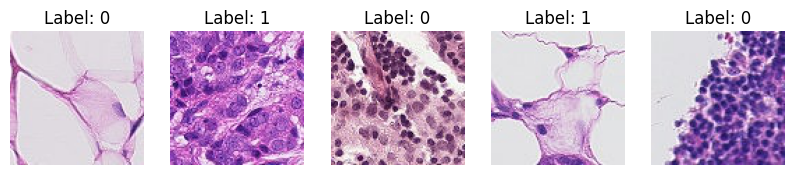

In [11]:
def display_images_with_labels(image_ids, labels, folder):
    plt.figure(figsize=(10, 10))
    for i, image_id in enumerate(image_ids):
        plt.subplot(1, len(image_ids), i + 1)
        image_path = os.path.join(folder, image_id + '.tif')
        image = Image.open(image_path)
        plt.imshow(image)
        plt.title(f'Label: {labels[i]}')
        plt.axis('off')
    plt.show()

# Select a few sample IDs and their corresponding labels
sample_images = labels_df.sample(5)
display_images_with_labels(sample_images['id'].tolist(), sample_images['label'].tolist(), 'train')


In [6]:
# Get basic statistics
print(labels_df.describe())

               label
count  220025.000000
mean        0.405031
std         0.490899
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000


Label Counts:
 label
0    130908
1     89117
Name: count, dtype: int64


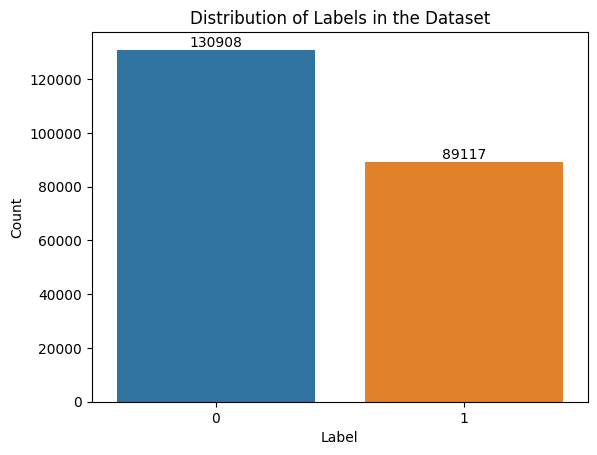

In [7]:
# Count the number of labels of each type
label_counts = labels_df['label'].value_counts()
print("Label Counts:\n", label_counts)

# Create a countplot
ax = sns.countplot(x='label', data=labels_df)
plt.title('Distribution of Labels in the Dataset')
plt.xlabel('Label')
plt.ylabel('Count')

# Adding label count
for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2., p.get_height(), '%d' % int(p.get_height()), 
            fontsize=10, ha='center', va='bottom')

plt.show()

In [8]:
# # Convert Images from TIF to PNG
# from PIL import Image
# import os

# def convert_tiff_to_png(source_folder, dest_folder):
#     if not os.path.exists(dest_folder):
#         os.makedirs(dest_folder)

#     for filename in os.listdir(source_folder):
#         if filename.endswith('.tif'):
#             image_path = os.path.join(source_folder, filename)
#             with Image.open(image_path) as img:
#                 png_path = os.path.join(dest_folder, filename.replace('.tif', '.png'))
#                 img.save(png_path)

# # Convert your training images
# # convert_tiff_to_png('train', 'train_png')
# # convert_tiff_to_png('test', 'test_png')

In [9]:
# Load the labels
labels_df = pd.read_csv('train/_labels.csv')

# Split data into training and validation sets
train_df, val_df = train_test_split(labels_df, test_size=0.2, random_state=42)

# Define a function to preprocess images
def preprocess_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, [96, 96])
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# Load and preprocess the training and validation data
train_data = tf.data.Dataset.from_tensor_slices((train_df['id'].apply(lambda x: f'train_png/{x}.png'), train_df['label']))
train_data = train_data.map(preprocess_image).batch(32).prefetch(tf.data.AUTOTUNE)

val_data = tf.data.Dataset.from_tensor_slices((val_df['id'].apply(lambda x: f'train_png/{x}.png'), val_df['label']))
val_data = val_data.map(preprocess_image).batch(32).prefetch(tf.data.AUTOTUNE)

2023-12-10 13:13:44.838140: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-10 13:13:44.893076: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-10 13:13:44.893125: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-10 13:13:44.903410: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-10 13:13:44.903463: I external/local_xla/xla/stream_executor

In [10]:
# # Building a simple CNN model (not the final model used in this project)
# model = tf.keras.models.Sequential([
#     tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)),
#     tf.keras.layers.MaxPooling2D(2, 2),
#     tf.keras.layers.Dropout(0.25),
#     tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2, 2),
#     tf.keras.layers.Dropout(0.25),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(64, activation='relu'),
#     tf.keras.layers.Dense(1, activation='sigmoid')
# ])

# new_learning_rate = 0.0001

# new_batch_size = 128 # 87.5% accuracy at 64 and 0.0001, 5 

# # Configure the optimizer with the new learning rate
# optimizer = tf.keras.optimizers.Adam(learning_rate=new_learning_rate)

# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# # Train the model
# history = model.fit(train_data, epochs=10, batch_size=new_batch_size, validation_data=val_data)

### Model Architecture
Data augmentation is used to enhance the model's capabilities on a diverse data set, rather than just the training data set. Techniques implemented below are image rotations, flips, and zooms.

A convolutional neural network (CNN) architecture, specifically leveraging a VGG16-based model, is used to address the challenge of identifying cancer in images. VGG16, a pre-trained model well-known for its effectiveness in image recognition tasks, is chosen as the base architecture. The model is adapted for the 96x96 pixel images of our dataset. VGG16 is generally pertained so it is a solid starting point.

The top layers of the model were customized to suit our binary classification task. This included a flattening layer, a dense layer with ReLU activation (for learning task-specific features), a drop-out layer (to prevent overfitting) and a final dense layer with sigmoid activation for binary classification. When researching CNNs, VGG16 came up as being effective in a variety of image recognition tasks. It allows for complex pattern and feature recognition, which makes sense for the subtle differences in the cancerous or non cancerous images. Using a pretrained model also helps with faster convergence and better generalization when the training data is limited.

Experimentation lead to decreasing the learning rate from 0.00001 to 0.000005 allowing for long term learning. The batch size of 64 was chosen to optimize performance on the server running the training. 200 epochs is chosen to see the long term learning rate. This training session took 14.05 hours.

In [12]:
# More complex CNN Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf

# Assuming loaded labels to dataframe
labels_df = pd.read_csv('train/_labels.csv')

# Split data into training and validation sets
train_df, val_df = train_test_split(labels_df, test_size=0.2, random_state=42)

# Convert labels to strings and append '.png' to image filenames
train_df['label'] = train_df['label'].astype(str)
val_df['label'] = val_df['label'].astype(str)
train_df['id'] = train_df['id'] + '.png'
val_df['id'] = val_df['id'] + '.png'

# Set the new learning rate and batch size
new_learning_rate = 0.000005 #0.00001
new_batch_size = 64

# Create ImageDataGenerators for training and validation sets
datagen_train = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    rescale=1./255
)

datagen_val = ImageDataGenerator(rescale=1./255)

# Create the generators
train_generator = datagen_train.flow_from_dataframe(
    dataframe=train_df,
    directory='./train_png/',
    x_col='id',
    y_col='label',
    target_size=(96, 96),
    batch_size=new_batch_size,
    class_mode='binary'
)

val_generator = datagen_val.flow_from_dataframe(
    dataframe=val_df,
    directory='./train_png/',
    x_col='id',
    y_col='label',
    target_size=(96, 96),
    batch_size=new_batch_size,
    class_mode='binary'
)

# Load the VGG16 pre-trained model
base_model = VGG16(input_shape=(96, 96, 3), include_top=False, weights='imagenet')

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Build the model
model = tf.keras.models.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),  # Increased dropout
    tf.keras.layers.Dense(1, activation='sigmoid')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=new_learning_rate)
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

#early_stopping = EarlyStopping(monitor='val_loss', patience=5)
model_checkpoint = ModelCheckpoint(
    'best_model.h5', 
    monitor='val_accuracy',
    save_best_only=True
)

# Compile and fit the model
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(
    train_generator,
    epochs=200,
    validation_data=val_generator,
    callbacks=[model_checkpoint] #early_stopping
)


Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.
Epoch 1/200


2023-12-10 13:13:47.952274: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2023-12-10 13:13:49.476628: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f993acc3450 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-10 13:13:49.476661: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2023-12-10 13:13:49.480346: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1702239229.537544   10056 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2751/2751 [==============================] - 261s 94ms/step - loss: 0.5762 - accuracy: 0.7068 - val_loss: 0.4599 - val_accuracy: 0.7893
Epoch 2/200


/home/riley/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2751/2751 [==============================] - 255s 93ms/step - loss: 0.4734 - accuracy: 0.7818 - val_loss: 0.4310 - val_accuracy: 0.8036
Epoch 3/200
2751/2751 [==============================] - 255s 93ms/step - loss: 0.4528 - accuracy: 0.7935 - val_loss: 0.4177 - val_accuracy: 0.8099
Epoch 4/200
2751/2751 [==============================] - 252s 92ms/step - loss: 0.4400 - accuracy: 0.8003 - val_loss: 0.4080 - val_accuracy: 0.8142
Epoch 5/200
2751/2751 [==============================] - 250s 91ms/step - loss: 0.4312 - accuracy: 0.8050 - val_loss: 0.4020 - val_accuracy: 0.8170
Epoch 6/200
2751/2751 [==============================] - 254s 92ms/step - loss: 0.4245 - accuracy: 0.8089 - val_loss: 0.3946 - val_accuracy: 0.8205
Epoch 7/200
2751/2751 [==============================] - 248s 90ms/step - loss: 0.4198 - accuracy: 0.8119 - val_loss: 0.3927 - val_accuracy: 0.8206
Epoch 8/200
2751/2751 [==============================] - 256s 93ms/step - loss: 0.4158 - accuracy: 0.8129 - val_loss: 0.3892

### Results:
The first set of graphs is from the simpler CNN model without image transformations. 64 batches 0.0001 learning rate and 10 epochs. Accuracy was at 86% at the 3rd epoch then continually decreases over time due to overfitting. The model is becoming more accurate at identifying cancer in the training pictures but not in a way that is generalizable to other data sets. This is not accomplishing the goal of the project because this model will not be effective on the testing data set.

The second set of graphs is from the simpler CNN model without image transformations. I did not record the hyperparameters for this run. Next project I would like to keep better track of each learn, so I can share with others and better learn from each attempt. There is still overfitting so the performance of this model was not going to improve over time to images outside the training set.

The third set of graphs is from the simpler CNN model without image transformations. 87.5% accuracy at 64 batches learning rate of 0.0001, and 5 epochs. I needed to better record my earlier testing. I believe I ran this test with more epochs and there was still overfitting present. The validation accuracy starts quite high, but will decrease over time.

The fourth set of graphs, produced by the code below, shows the final code for this project. After showing early promise after 10 epochs at 0.000005 learning rate and 64 batches, this setup was ran over 200 epochs. This graph is different from the previous, there does not seem to be any overfitting. Over time training provides more accurate identification of cancer in the training data and in the validation data.  

Troubleshooting took several hours, documentation and carefully reading errors throughout this project kept it moving. I also spend many hours setting up a GPU for training, but was finally set up in a short time once following official documentation on version compatibility and installations instructions specific to WSL running Ubuntu.

![Image Description 1](IMG_0010.jpg)
![Image Description 2](IMG_0020.jpg)
![Image Description 3](IMG_0021.jpg)


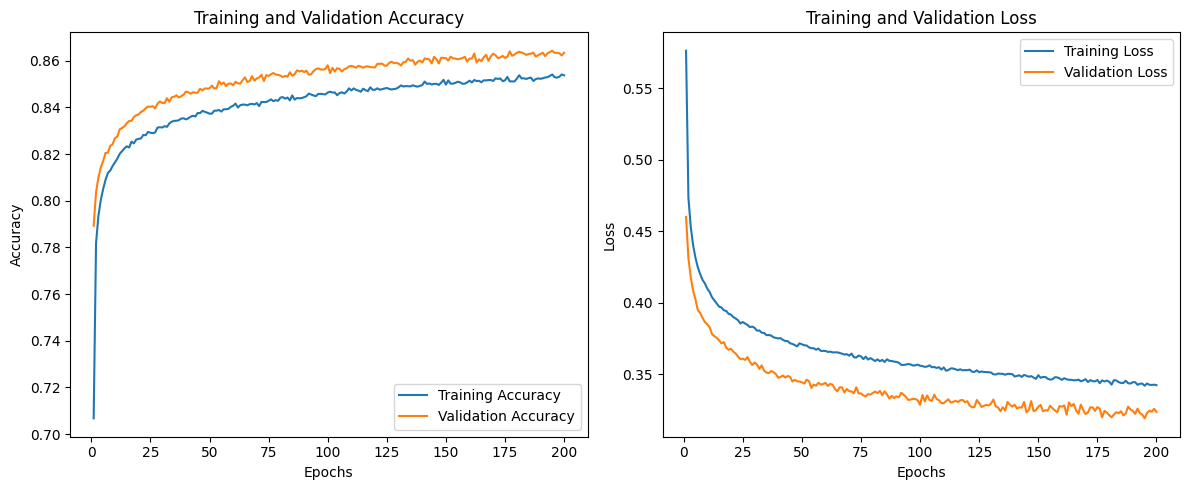

In [13]:
import matplotlib.pyplot as plt

history_dict = history.history

# Extracting the metrics
training_accuracy = history_dict['accuracy']
validation_accuracy = history_dict['val_accuracy']
training_loss = history_dict['loss']
validation_loss = history_dict['val_loss']
epochs = range(1, len(training_accuracy) + 1)

# Plotting training and validation accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, training_accuracy, label='Training Accuracy')
plt.plot(epochs, validation_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [14]:
# Evaluate the model
loss, accuracy = model.evaluate(val_data)
print(f"Validation accuracy: {accuracy}")

1376/1376 [==============================] - 34s 24ms/step - loss: 0.3235 - accuracy: 0.8635
Validation accuracy: 0.8634700775146484


In [22]:
# model.save('my_model.keras')

In [5]:
# Test images directory and IDs 
test_images_dir = './test_png/'
test_ids = [filename.split('.')[0] for filename in os.listdir(test_images_dir) if filename.endswith('.png')]

# Preprocessing function
def preprocess_test_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, [96, 96])
    image = tf.cast(image, tf.float32) / 255.0
    return image

# Load trained model
model = tf.keras.models.load_model('my_model.keras')  # Update path if needed

def load_and_preprocess_image(image_id):
    file_path = f'{test_images_dir}/{image_id}.png'
    return preprocess_test_image(file_path)

# Generator function to yield preprocessed images
def image_generator(image_ids, batch_size):
    for i in range(0, len(image_ids), batch_size):
        batch_ids = image_ids[i:i + batch_size]
        batch_images = [load_and_preprocess_image(image_id) for image_id in batch_ids]
        yield np.array(batch_images)
        
batch_size = 16

# Predict using the generator
predictions = []
for batch_images in image_generator(test_ids, batch_size):
    batch_predictions = model.predict(batch_images)
    predictions.extend(batch_predictions.flatten())

predictions = np.array(predictions).clip(0, 1)

# Create a DataFrame for submission
submission_df = pd.DataFrame({'id': test_ids, 'label': predictions})
submission_df.to_csv('submission.csv', index=False)

2023-12-11 14:19:04.885743: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902


1/1 [==============================] - 0s 271ms/step


### Conclusion
In this project, the challenge is to classify each image as either containing cancerous tissue or not. After several iterations of the model, increasing dropout rate, decreasing learning rate, and extending the epochs once my model was learning longer term. It was able to get 86.35% accuracy on the validation, 20%, of the training data. The model might have become more accurate with even more training time. It is clear a large training data set can greatly improve generalization of the model.

Applying the trained model to the test data resulted in a score of 0.9045 and Public score of 0.9097.

The computational constraints and hyperparameter provided insights into how deep learning can be applied to medical imaging. In the future different models can be applied and compared to find one that is optimal.

![Image Description 1](IMG_0111.png)
![Image Description 2](IMG_0112.png)

Citations:

Kaggle. (n.d.). Histopathologic Cancer Detection. Retrieved from https://www.kaggle.com/competitions/histopathologic-cancer-detection/overview

Simonyan, K., & Zisserman, A. (2014). Very Deep Convolutional Networks for Large-Scale Image Recognition. arXiv preprint arXiv:1409.1556. Available at: https://arxiv.org/abs/1409.1556